In [3]:
%load_ext autoreload
%autoreload 2

import ast
import json
import pandas as pd
import numpy as np
from keras.models import load_model
from research.utils.data_access_utils import S3AccessUtils, RDSAccessUtils
# from weight_estimation.dataset import prepare_gtsf_data, compute_akpd_score
# from weight_estimation.train import train, augment, normalize, get_data_split, train_model
from typing import Dict, Tuple


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
UPPER_LIP = 'UPPER_LIP'
EYE = 'EYE'
PECTORAL_FIN = 'PECTORAL_FIN'
DORSAL_FIN = 'DORSAL_FIN'
PELVIC_FIN = 'PELVIC_FIN'
ADIPOSE_FIN = 'ADIPOSE_FIN'
ANAL_FIN = 'ANAL_FIN'
TAIL_NOTCH = 'TAIL_NOTCH'
UPPER_PRECAUDAL_PIT = 'UPPER_PRECAUDAL_PIT'
LOWER_PRECAUDAL_PIT = 'LOWER_PRECAUDAL_PIT'
HYPURAL_PLATE = 'HYPURAL_PLATE'

core_body_parts = sorted([UPPER_LIP,
                          EYE,
                          PECTORAL_FIN,
                          DORSAL_FIN,
                          PELVIC_FIN,
                          ADIPOSE_FIN,
                          ANAL_FIN,
                          TAIL_NOTCH])

auxiliary_body_parts = sorted([UPPER_PRECAUDAL_PIT,
                               LOWER_PRECAUDAL_PIT,
                               HYPURAL_PLATE])

all_body_parts = sorted(core_body_parts + auxiliary_body_parts)

body_parts = {
    'core_body_parts': core_body_parts
}

In [18]:
from collections import namedtuple
from typing import Dict, List, Tuple
import numpy as np

CameraMetadata = namedtuple('CameraMetadata',
                            ['focal_length', 'focal_length_pixel', 'baseline_m', 'pixel_count_width',
                             'pixel_count_height', 'image_sensor_width', 'image_sensor_height'])


def get_left_right_keypoint_arrs(annotation: Dict[str, List[Dict]]) -> Tuple:
    """Gets numpy array of left and right keypoints given input keypoint annotation.
    Args:
        annotation: dict with keys 'leftCrop' and 'rightCrop'. Values are lists where each element
        is a dict with keys 'keypointType', 'xCrop' (num pixels from crop left edge),
        'yCrop' (num pixels from crop top edge), 'xFrame' (num pixels from full frame left edge),
        and 'yFrame' (num pixels from full frame top edge).
    Returns:
        X_left: numpy array containing left crop (xFrame, yFrame) for each key-point ordered
        alphabetically.
        X_right: same as above, but for right crop.
    """

    left_keypoints, right_keypoints = {}, {}
    for item in annotation['leftCrop']:
        body_part = item['keypointType']
        left_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    for item in annotation['rightCrop']:
        body_part = item['keypointType']
        right_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    left_keypoint_arr, right_keypoint_arr = [], []
    for body_part in body_parts['core_body_parts']:
        left_keypoint_arr.append(left_keypoints[body_part])
        right_keypoint_arr.append(right_keypoints[body_part])

    X_left = np.array(left_keypoint_arr)
    X_right = np.array(right_keypoint_arr)
    return X_left, X_right

def get_ann_from_keypoint_arrs(X_left: np.ndarray, X_right: np.ndarray) -> Dict:
    """Constructs annotation from left and right key-point arrays (i.e. inverse of
    get_left_right_keypoint_arrs method."""

    ann = {'leftCrop': [], 'rightCrop': []}
    for idx in range(X_left.shape[0]):
        x_left, y_left = tuple(X_left[idx, :])
        x_right, y_right = tuple(X_right[idx, :])
        body_part = body_parts['core_body_parts'][idx]
        left_item = dict(keypointType=body_part, xFrame=x_left, yFrame=y_left)
        right_item = dict(keypointType=body_part, xFrame=x_right, yFrame=y_right)
        ann['leftCrop'].append(left_item)
        ann['rightCrop'].append(right_item)

    return ann

def convert_to_nn_input(annotation: Dict[str, List[Dict]], camera_metadata: CameraMetadata) \
        -> np.ndarray:
    """Converts input keypoint annotation and camera metadata into neural network tensor input."""
    X_left, X_right = get_left_right_keypoint_arrs(annotation)
    X_left_norm, X_right_norm = normalize_left_right_keypoint_arrs(X_left, X_right)
    X_world = convert_to_world_point_arr(X_left_norm, X_right_norm, camera_metadata)
    X = stabilize_keypoints(X_world).reshape(1, -1)
    return X

def convert_to_world_point_arr(X_left: np.ndarray, X_right: np.ndarray,
                               camera_metadata: CameraMetadata) -> np.ndarray:
    """Converts input left and right normalized keypoint arrays into world coordinate array."""

    y_world = camera_metadata.focal_length_pixel * camera_metadata.baseline_m / \
              (X_left[:, 0] - X_right[:, 0])

    # Note: the lines commented out below are technically the correct formula for conversion
    # x_world = X_left[:, 0] * y_world / camera_metadata.focal_length_pixel
    # z_world = -X_left[:, 1] * y_world / camera_metadata.focal_length_pixel
    x_world = ((X_left[:, 0] * camera_metadata.image_sensor_width / camera_metadata.pixel_count_width) * y_world) / (camera_metadata.focal_length)
    z_world = (-(X_left[:, 1] * camera_metadata.image_sensor_height / camera_metadata.pixel_count_height) * y_world) / (camera_metadata.focal_length)
    X_world = np.vstack([x_world, y_world, z_world]).T
    return X_world

In [13]:
from typing import Dict, List
import json, os
import numpy as np
import pandas as pd
from keras.models import load_model
from research.weight_estimation.akpd_utils.akpd_scorer import generate_confidence_score
from research.utils.data_access_utils import S3AccessUtils, RDSAccessUtils

# generate raw GTSF dataframe from database
def generate_raw_df(start_date, end_date):
    rds = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
    query = """
        select * from research.fish_metadata a left join keypoint_annotations b
        on a.left_url = b.left_image_url 
        where b.keypoints -> 'leftCrop' is not null
        and b.keypoints -> 'rightCrop' is not null
        and b.captured_at between '{0}' and '{1}';
    """.format(start_date, end_date)
    df = rds.extract_from_database(query)
    return df


def process(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df.data.apply(lambda x: x['species'].lower()) == 'salmon'].copy(deep=True)
    qa_df = df[df.is_qa == True]
    cogito_df = df[(df.is_qa != True) & ~(df.left_image_url.isin(qa_df.left_image_url))]
    df = pd.concat([qa_df, cogito_df], axis=0)
    return df


def compute_akpd_score(akpd_scorer_network, keypoints: Dict, camera_metadata: Dict) -> float:
    input_sample = {
        'keypoints': keypoints,
        'cm': camera_metadata,
        'stereo_pair_id': 0,
        'single_point_inference': True
    }

    akpd_score = generate_confidence_score(input_sample, akpd_scorer_network)
    return akpd_score


def generate_akpd_scores(df: pd.DataFrame, akpd_scorer_f: str) -> List[float]:
    akpd_scorer_network = load_model(akpd_scorer_f)
    akpd_scores = []
    count = 0
    for _, row in df.iterrows():
        if count % 1000 == 0:
            print('Percentage complete: {}%'.format(round(100 * count / df.shape[0], 2)))
        count += 1
        akpd_score = compute_akpd_score(akpd_scorer_network, row.keypoints, row.camera_metadata)
        akpd_scores.append(akpd_score)
    return akpd_scores


def generate_depths(df: pd.DataFrame):
    depths = []
    for _, row in df.iterrows():
        annotation = row.keypoints
        camera_metadata = row.camera_metadata
        cm = CameraMetadata(
            focal_length=camera_metadata['focalLength'],
            focal_length_pixel=camera_metadata['focalLengthPixel'],
            baseline_m=camera_metadata['baseline'],
            pixel_count_width=camera_metadata['pixelCountWidth'],
            pixel_count_height=camera_metadata['pixelCountHeight'],
            image_sensor_width=camera_metadata['imageSensorWidth'],
            image_sensor_height=camera_metadata['imageSensorHeight']
        )
        X_left, X_right = get_left_right_keypoint_arrs(annotation)
        X_world = convert_to_world_point_arr(X_left, X_right, cm)
        depths.append(np.mean(X_world[:, ]))
    return depths


def prepare_gtsf_data(start_date: str, end_date: str, akpd_scorer_f: str,
                      akpd_score_cutoff: float, depth_cutoff: float) -> pd.DataFrame:
    df = generate_raw_df(start_date, end_date)
    print('Raw data loaded!')
    df = process(df)
    print('Data preprocessed!')
    df['k_factor'] = 1e5 * df.weight / df.data.apply(lambda x: x['lengthMms']**3).astype(float)
    df['akpd_score'] = generate_akpd_scores(df, akpd_scorer_f)
    df['depth'] = generate_depths(df)
    mask = (df.akpd_score > akpd_score_cutoff) & (df.depth < depth_cutoff)
    df = df[mask].copy(deep=True)
    return df

In [14]:
from collections import defaultdict
import json
import os
import random
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
from keras.layers import Input, Dense
from keras.models import Model
import keras
from research.utils.data_access_utils import S3AccessUtils


def augment(df: pd.DataFrame, augmentation_config: Dict) -> pd.DataFrame:
    print('hello')
    # trials = augmentation_config['trials']
    counts, _ = np.histogram(df.weight, bins=np.arange(0, 10000, 1000))
    trial_values = (5.0 / (counts / np.max(counts))).astype(int)
    max_jitter_std = augmentation_config['max_jitter_std']
    min_scaling_factor = augmentation_config['min_scaling_factor']
    max_scaling_factor = augmentation_config['max_scaling_factor']

    augmented_data = defaultdict(list)
    for _, row in df.iterrows():
        weight = row.weight
        trials = trial_values[min(int(weight / 1000), len(trial_values) - 1)]
        for _ in range(trials):
            scaling_factor = np.random.uniform(min_scaling_factor, max_scaling_factor)
            jitter_std = np.random.uniform(0, max_jitter_std)
            ann = row.keypoints
            X_left, X_right = get_left_right_keypoint_arrs(ann)

            # rescale
            X_left = X_left * scaling_factor
            X_right = X_right * scaling_factor

            # add jitter
            X_left[:, 0] += np.random.normal(0, jitter_std, X_left.shape[0])
            X_right[:, 0] += np.random.normal(0, jitter_std, X_right.shape[0])

            # reconstruct annotation
            ann = get_ann_from_keypoint_arrs(X_left, X_right)
            augmented_data['annotation'].append(ann)
            augmented_data['fish_id'].append(row.fish_id)
            augmented_data['weight'].append(row.weight)
            augmented_data['kf'].append(row.k_factor)
            augmented_data['camera_metadata'].append(row.camera_metadata)

    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df


def normalize(anns: List, camera_metadatas: List) -> np.ndarray:
    norm_anns = []
    for ann, camera_metadata in zip(anns, camera_metadatas):

        cm = CameraMetadata(
            focal_length=camera_metadata['focalLength'],
            focal_length_pixel=camera_metadata['focalLengthPixel'],
            baseline_m=camera_metadata['baseline'],
            pixel_count_width=camera_metadata['pixelCountWidth'],
            pixel_count_height=camera_metadata['pixelCountHeight'],
            image_sensor_width=camera_metadata['imageSensorWidth'],
            image_sensor_height=camera_metadata['imageSensorHeight']
        )

        norm_ann = convert_to_nn_input(ann, cm)
        norm_anns.append(norm_ann)
    return np.array(norm_anns)


def get_data_split(X: np.ndarray, y: np.ndarray, fish_ids: np.ndarray, train_pct: float,
                   val_pct: float) -> Tuple:
    # select train / test sets such that there are no overlapping fish IDs

    test_pct = 1.0 - train_pct - val_pct
    unique_fish_ids = np.array(list(set(fish_ids)))
    train_cnt, val_cnt, test_cnt = np.random.multinomial(len(unique_fish_ids),
                                                         [train_pct, val_pct, test_pct])

    assignments = np.array([0] * train_cnt + [1] * val_cnt + [2] * test_cnt)
    np.random.shuffle(assignments)
    train_fish_ids = unique_fish_ids[np.where(assignments == 0)]
    val_fish_ids = unique_fish_ids[np.where(assignments == 1)]
    test_fish_ids = unique_fish_ids[np.where(assignments == 2)]

    train_mask = np.isin(fish_ids, train_fish_ids)
    val_mask = np.isin(fish_ids, val_fish_ids)
    test_mask = np.isin(fish_ids, test_fish_ids)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    return X_train, y_train, X_val, y_val, X_test, y_test


def train_model(X_train, y_train, X_val, y_val, train_config):
    inputs = Input(shape=(24,))
    x = Dense(256, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    pred = Dense(1)(x)
    model = Model(inputs, pred)

    epochs = train_config['epochs']
    batch_size = train_config['batch_size']
    lr = train_config['learning_rate']
    patience = train_config['patience']

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=patience,
                                               verbose=0,
                                               mode='auto')]

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=callbacks,
              batch_size=batch_size, epochs=epochs)

    return model


def density_scatter(x, y, bins=20, **kwargs):
    fig, ax = plt.subplots(figsize=(20, 10))
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T,
                method="splinef2d", bounds_error=False)

    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)

    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(colormap.ScalarMappable(norm=norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    ax.grid()

    return ax


def generate_accuracy_details(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train).squeeze().astype(float)
    y_test_pred = model.predict(X_test).squeeze().astype(float)
    ax_train = density_scatter(1e4 * y_train, 1e4 * y_train_pred)
    ax_test = density_scatter(1e4 * y_test, 1e4 * y_test_pred)
    train_stats = {
        'mean_absolute_error_pct': 100 * np.mean(np.abs((y_train_pred - y_train) / y_train)),
        'mean_error_pct': 100 * np.mean(y_train_pred - y_train) / np.mean(y_train)
    }
    test_stats = {
        'mean_absolute_error_pct': 100 * np.mean(np.abs((y_test_pred - y_test) / y_test)),
        'mean_error_pct': 100 * np.mean(y_test_pred - y_test) / np.mean(y_test)
    }

    return ax_train, ax_test, train_stats, test_stats


def train(df, augmentation_config, train_config, weight):
    print('here')
    random.seed(0)
    np.random.seed(0)
    augmented_df = augment(df, augmentation_config)
    anns = augmented_df.annotation.values.tolist()
    cms = augmented_df.camera_metadata.values.tolist()
    X = normalize(anns, cms)

    if weight:
        y = 1e-4 * augmented_df.weight.values
    else:
        y = (augmented_df.kf.values - 1.2) / 0.3
    print(y)
    fish_ids = augmented_df.fish_id.values
    X_train, y_train, X_val, y_val, X_test, y_test = get_data_split(X, y, fish_ids,
                                                                    train_config['train_pct'],
                                                                    train_config['val_pct'])
    model = train_model(X_train, y_train, X_val, y_val, train_config)
    ax_train, ax_test, train_stats, test_stats = \
        generate_accuracy_details(model, X_train, y_train, X_test, y_test)
    return model, ax_train, ax_test, train_stats, test_stats


In [4]:
# KP = ["TAIL_NOTCH", "ADIPOSE_FIN", "UPPER_LIP", "ANAL_FIN", "PELVIC_FIN", "EYE", "PECTORAL_FIN", "DORSAL_FIN"]


In [ ]:
# df = pd.read_csv('/root/data/alok/biomass_estimation/playground/gtsf_keypoints_new.csv')

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = false;

In [19]:
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))
akpd_scorer_url = 'https://aquabyte-models.s3-us-west-1.amazonaws.com/keypoint-detection-scorer/akpd_scorer_model_TF.h5'
akpd_scorer_f, _, _ = s3.download_from_url(akpd_scorer_url)
df1 = prepare_gtsf_data('2019-03-01', '2019-09-20', akpd_scorer_f, 0.5, 1.0)

df2 = prepare_gtsf_data('2020-06-01', '2020-08-20', akpd_scorer_f, 0.5, 1.0)
df = pd.concat([df1, df2])

Raw data loaded!
Data preprocessed!
Percentage complete: 0.0%
Percentage complete: 6.39%
Percentage complete: 12.78%
Percentage complete: 19.17%
Percentage complete: 25.56%
Percentage complete: 31.94%
Percentage complete: 38.33%
Percentage complete: 44.72%
Percentage complete: 51.11%
Percentage complete: 57.5%
Percentage complete: 63.89%
Percentage complete: 70.28%
Percentage complete: 76.67%
Percentage complete: 83.06%
Percentage complete: 89.45%
Percentage complete: 95.83%
Raw data loaded!
Data preprocessed!
Percentage complete: 0.0%


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [64]:
df.to_csv('/root/data/bryton/gtsf.csv')

In [ ]:
from filter_optimization.filter_optimization_task import extract_biomass_data

gt_metadata = {'pen_id': 144,
 'gutted_average_weight': 8000,
 'gutted_weight_distribution': None,
 'expected_loss_factor': 0.16,
 'last_feeding_date': '2021-01-11',
 'harvest_date': '2021-01-15',
 'slaughter_date': '2021-01-15'}

df2 = extract_biomass_data(gt_metadata['pen_id'], '2021-01-01', '2021-01-12', 0.01)

In [ ]:
import numpy as np
import json
from functools import singledispatch


@singledispatch
def to_serializable(val):
    """Used by default."""
    return str(val)


@to_serializable.register(np.float32)
def ts_float32(val):
    """Used if *val* is an instance of numpy.float32."""
    return np.float64(val)

In [ ]:
json.dump(keypoints_new, open('/root/data/alok/biomass_estimation/playground/keypoints_new.json', 'w'), default=to_serializable)



In [62]:
df.head()

,left_url,fish_id,weight,data,stereo_parameters_url,ts_created,ts_updated,data_collection_type_id,id,fish_detection_id,...,left_crop_metadata,right_crop_metadata,camera_metadata,captured_at,is_obscured_floy_tag,is_floy_tag_not_present,k_factor,akpd_score,depth,keypoints_new_crop
0,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190607010048_bolaks-mjanes,4976,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 04:51:53.137423+00:00,2019-08-09 04:51:53.137423+00:00,None,513838,None,...,"{'width': 2958, 'height': 887, 'x_coord': 925,...","{'width': 2972, 'height': 896, 'x_coord': 531,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-06-07 11:17:33.444000+00:00,None,None,1.327622,0.983300,0.280849,"{'leftCrop': [{'xCrop': 2845, 'yCrop': 525, 'x..."
1,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190607010041_bolaks-mjanes,5571,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 04:51:53.761697+00:00,2019-08-09 04:51:53.761697+00:00,None,513974,None,...,"{'width': 2656, 'height': 1660, 'x_coord': 104...","{'width': 2659, 'height': 1720, 'x_coord': 594...","{'baseline': 0.12693501988129197, 'focalLength...",2019-06-07 10:51:19.235000+00:00,None,None,1.524106,0.991292,0.267675,"{'leftCrop': [{'xCrop': 2464, 'yCrop': 312, 'x..."
2,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190607010041_bolaks-mjanes,5571,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 04:51:58.764858+00:00,2019-08-09 04:51:58.764858+00:00,None,513938,None,...,"{'width': 2566, 'height': 2122, 'x_coord': 101...","{'width': 2662, 'height': 2095, 'x_coord': 449...","{'baseline': 0.12693501988129197, 'focalLength...",2019-06-07 11:00:31.233000+00:00,None,None,1.524106,0.998707,0.257723,"{'leftCrop': [{'xCrop': 2295, 'yCrop': 1763, '..."
3,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190607010004_bolaks-mjanes,4963,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 04:52:00.015111+00:00,2019-08-09 04:52:00.015111+00:00,None,513945,None,...,"{'width': 2762, 'height': 813, 'x_coord': 983,...","{'width': 2737, 'height': 827, 'x_coord': 575,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-06-07 08:07:37.747000+00:00,None,None,1.628168,0.996094,0.278704,"{'leftCrop': [{'xCrop': 2615, 'yCrop': 412, 'x..."
4,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190607010045_bolaks-mjanes,4760,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 04:52:01.264800+00:00,2019-08-09 04:52:01.264800+00:00,None,514005,None,...,"{'width': 2763, 'height': 862, 'x_coord': 875,...","{'width': 2714, 'height': 885, 'x_coord': 422,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-06-07 11:12:22.538000+00:00,None,None,1.575576,0.994926,0.259930,"{'leftCrop': [{'xCrop': 2655, 'yCrop': 545, 'x..."


In [61]:
df['keypoints_new_crop'] = keypoints_new_crop

In [63]:
df.to_csv('/root/data/bryton/gtsf_heatmap.csv')

In [ ]:
len(keypoints_new_crop)

In [45]:
keypoints_new_crop[0]['leftCrop'][0]

{'xCrop': 2845,
 'yCrop': 525,
 'xCropNew': 2848,
 'yCropNew': 528,
 'xFrame': 3770,
 'yFrame': 1556,
 'xFrameNew': 3773,
 'yFrameNew': 1559,
 'score': 0.7335928,
 'scoreAvg': 0.32478037,
 'scoreMax': 0.7727444,
 'keypointType': 'TAIL_NOTCH'}

In [112]:
weights = []
depths = []
scores = []
akpd_scores = []

for index, row in df.iterrows():
    weights.append(row['data']['weightKgs'])
    depths.append(row['depth'])
    akpd_scores.append(row['akpd_score'])
    
for row in keypoints_new_crop:
    all_scores = []
    
    for kp in row['leftCrop']:
        all_scores.append(kp['scoreMax'])
    
    scores.append(np.mean(all_scores))



In [104]:
np.corrcoef(np.array([weights, depths, scores, akpd_scores]))

array([[ 1.        , -0.33220886,  0.2405703 , -0.06520308],
       [-0.33220886,  1.        , -0.16190257,  0.02991022],
       [ 0.2405703 , -0.16190257,  1.        ,  0.10005352],
       [-0.06520308,  0.02991022,  0.10005352,  1.        ]])

In [87]:
# np.corrcoef(weights, akpd_scores)
np.corrcoef(akpd_scores[0:len(scores)], scores)

array([[ 1.        , -0.35260249],
       [-0.35260249,  1.        ]])

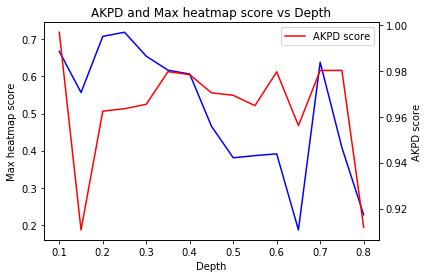

In [120]:
depths = np.array(depths)
scores = np.array(scores)
akpd_scores = np.array(akpd_scores)

depth_ranges = np.arange(0, 1, 0.05)

depth_score = []
depth_akpd_score = []

for depth_range in depth_ranges:
    mask = (depths > depth_range) & (depths < depth_range + .05)
#     print(depth_range, sum(mask))
    depth_score.append(np.mean(scores[mask]))
    depth_akpd_score.append(np.mean(akpd_scores[mask]))
    
fig, ax = plt.subplots()

ax1 = ax.twinx()
    
ax.plot(depth_ranges, depth_score, color = 'blue', label = 'Heatmap AKPD score')
ax1.plot(depth_ranges, depth_akpd_score, color = 'red', label = 'AKPD score')
ax.set_xlabel('Depth')
ax.set_ylabel('Max heatmap score')
ax1.set_ylabel('AKPD score')
ax.set_title('AKPD and Max heatmap score vs Depth')
ax1.legend()

In [59]:
count

15367

In [58]:
# keypoints_new_crop = []

count = 0

for index, row in df.iterrows():
    if count % 100 == 0:
        print(count, 'out of', len(df))

    count = count + 1
    
    if count < 13101:
        continue
        
    oL, oR, kpL, kpR, kpLScore, kpRScore, kpLScoreAvg, kpRScoreAvg, kpLScoreMax, kpRScoreMax = get_keypoints_with_crop(row)
    
    newKeypoints = {
        'leftCrop': [],
        'rightCrop': []
    }
    
    left_crop_metadata = row.left_crop_metadata
    right_crop_metadata = row.right_crop_metadata
    
    for i in np.arange(0, len(KP), 1):
        newKeypoints['leftCrop'].append({
            'xCrop': oL[i][0],
            'yCrop': oL[i][1],
            'xCropNew': kpL[i][0],
            'yCropNew': kpL[i][1],
            'xFrame': oL[i][0] + left_crop_metadata['x_coord'],
            'yFrame': oL[i][1] + left_crop_metadata['y_coord'],
            'xFrameNew': kpL[i][0] + left_crop_metadata['x_coord'],
            'yFrameNew': kpL[i][1] + left_crop_metadata['y_coord'],
            'score': kpLScore[i],
            'scoreAvg': kpLScoreAvg[i],
            'scoreMax': kpLScoreMax[i],
            'keypointType': KP[i]
        })
        
        newKeypoints['rightCrop'].append({
            'xCrop': oR[i][0],
            'yCrop': oR[i][1],
            'xCropNew': kpR[i][0],
            'yCropNew': kpR[i][1],
            'xFrame': oR[i][0] + right_crop_metadata['x_coord'],
            'yFrame': oR[i][1] + right_crop_metadata['y_coord'],
            'xFrameNew': kpR[i][0] + right_crop_metadata['x_coord'],
            'yFrameNew': kpR[i][1] + right_crop_metadata['y_coord'],
            'score': kpRScore[i],
            'scoreAvg': kpRScoreAvg[i],
            'scoreMax': kpRScoreMax[i],
            'keypointType': KP[i]
        })
        
    keypoints_new_crop.append(newKeypoints)

0 out of 15367
100 out of 15367
200 out of 15367
300 out of 15367
400 out of 15367
500 out of 15367
600 out of 15367
700 out of 15367
800 out of 15367
900 out of 15367
1000 out of 15367
1100 out of 15367
1200 out of 15367
1300 out of 15367
1400 out of 15367
1500 out of 15367
1600 out of 15367
1700 out of 15367
1800 out of 15367
1900 out of 15367
2000 out of 15367
2100 out of 15367
2200 out of 15367
2300 out of 15367
2400 out of 15367
2500 out of 15367
2600 out of 15367
2700 out of 15367
2800 out of 15367
2900 out of 15367
3000 out of 15367
3100 out of 15367
3200 out of 15367
3300 out of 15367
3400 out of 15367
3500 out of 15367
3600 out of 15367
3700 out of 15367
3800 out of 15367
3900 out of 15367
4000 out of 15367
4100 out of 15367
4200 out of 15367
4300 out of 15367
4400 out of 15367
4500 out of 15367
4600 out of 15367
4700 out of 15367
4800 out of 15367
4900 out of 15367
5000 out of 15367
5100 out of 15367
5200 out of 15367
5300 out of 15367
5400 out of 15367
5500 out of 15367
5600

In [ ]:
# config_bak_path = '/root/data/bati/model/config.json'
# config_bak = json.load(open(config_bak_path))
# config_bak

In [24]:
import cv2
import urllib
import tensorflow as tf

config_path = '/root/data/bryton/akpd_production_config.json'
# config_path = '/root/data/bati/model/config_4_stage.json'

checkpoint_path = '/root/data/bryton/model_499.pb'
config = json.load(open(config_path))

class FLAGS(object):
    input_size = tuple(config["input_size"])
    stages = config["cpm_stages"]
    batch_size = config["batch_size"]
    joints = config["num_of_joints"]
    model_path = checkpoint_path
    cmap_radius = config["center_radius"]
    keypoints_order = config["keypoints_order"]
    normalize = config["normalize"]
    heatmap_size = 512#config["heatmap_size"]
    joint_gaussian_variance = config["joint_gaussian_variance"]
    crop = config["crop"]
    augmentation = None
    
def load_pb(path_to_pb):
    with tf.io.gfile.GFile(path_to_pb, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, input_map=None,
                                return_elements=None,
                                name="",
                                op_dict=None,
                                producer_op_list=None)
        graph_nodes=[n for n in graph_def.node]
#         for t in graph_nodes:
#             print(t.name)
        return graph

mod = load_pb(checkpoint_path)

sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

sess.graph.as_default()
sess.run(tf.compat.v1.global_variables_initializer())

tf_device = '/gpu:0'
with tf.device(tf_device):
    model = mod

Instructions for updating:
Please file an issue at https://github.com/tensorflow/tensorflow/issues if you depend on this feature.


In [25]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def image_resize(image, FLAGS):
    height, width, _ = image.shape
    ratio_width = width / FLAGS.input_size[0]
    ratio_height = height / FLAGS.input_size[1]
    image = cv2.resize(image, FLAGS.input_size)
    image  = image / 255.0 - 0.5
    image = image[np.newaxis, ...]
    return image

def enhance(image, clip_limit=5):
    # convert image to LAB color model
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert image from LAB color model back to RGB color model
    final_image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    return final_image 


In [26]:
def get_keypoints(row):
    imL = row['left_image_url']
    imR = row['right_image_url']
    lco = row['left_crop_metadata']
    rco = row['right_crop_metadata']
    meta = row['camera_metadata']

    imageL = url_to_image(imL)
    imageR = url_to_image(imR)
    
    

    img1 = enhance(imageL)
    img2 = enhance(imageR)

    heightL, widthL, _ = img1.shape
    img_input = image_resize(img1, FLAGS)
    with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
        predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
    final_stage_heatmapL = predict_heatmap.squeeze()

    heightR, widthR, _ = img2.shape
    img_input = image_resize(img2, FLAGS)
    with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
        predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
    final_stage_heatmapR = predict_heatmap.squeeze()

    oL = [] # original left key-points using max method
    oR = [] # original right key-points using max method
    kpL = [] # new left key-points using avg method
    kpR = [] # new right key-points using avg method
    kpLScore = []
    kpRScore = []
    kpLScoreAvg = []
    kpRScoreAvg = []
    kpLScoreMax = []
    kpRScoreMax = []

    for c in np.arange(0, len(KP), 1):
        hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))
        hm_maxL = list(np.where(hm == hm.max()))   
        
        ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape) # 2D locations corresponding to highest 10000 heatmap values
        x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
        y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))

        oL.append([int(hm_maxL[1][0]), int(hm_maxL[0][0])]) 
        kpL.append([int(np.rint(x)), int(np.rint(y))])
        kpLScore.append(hm[int(np.rint(y)), int(np.rint(x))])
        kpLScoreAvg.append(np.mean(hm[ii]))
        kpLScoreMax.append(hm.max())

        hm = cv2.resize(final_stage_heatmapR[..., c], (widthR, heightR))
        hm_maxR = np.where(hm == hm.max())
    
        ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
        x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
        y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))

        oR.append([int(hm_maxR[1][0]), int(hm_maxR[0][0])])
        kpR.append([int(np.rint(x)), int(np.rint(y))])
        kpRScore.append(hm[int(np.rint(y)), int(np.rint(x))])
        kpRScoreAvg.append(np.mean(hm[ii]))
        kpRScoreMax.append(hm.max())

    return oL, oR, kpL, kpR, kpLScore, kpRScore, kpLScoreAvg, kpRScoreAvg, kpLScoreMax, kpRScoreMax 

In [29]:
def get_keypoints_with_crop(row):
    imL = row['left_image_url']
    imR = row['right_image_url']
    lco = row['left_crop_metadata']
    rco = row['right_crop_metadata']
    meta = row['camera_metadata']
    gt_keypoints = row['keypoints']

    # imL = row['left_crop_url']
    # imR = row['right_crop_url']
    # lco = row['left_crop_metadata']
    # rco = row['right_crop_metadata']
    # meta = row['camera_metadata']

    imageL = url_to_image(imL)
    imageR = url_to_image(imR)

    leftCrop = [meta['pixelCountWidth'], 0, meta['pixelCountHeight'], 0]
    rightCrop = [meta['pixelCountWidth'], 0, meta['pixelCountHeight'], 0]

    for keypoint in gt_keypoints['leftCrop']:
        leftCrop[0] = min(leftCrop[0], keypoint['xCrop'])
        leftCrop[1] = max(leftCrop[1], keypoint['xCrop'])
        leftCrop[2] = min(leftCrop[2], keypoint['yCrop'])
        leftCrop[3] = max(leftCrop[3], keypoint['yCrop'])

    for keypoint in gt_keypoints['rightCrop']:
        rightCrop[0] = min(rightCrop[0], keypoint['xCrop'])
        rightCrop[1] = max(rightCrop[1], keypoint['xCrop'])
        rightCrop[2] = min(rightCrop[2], keypoint['yCrop'])
        rightCrop[3] = max(rightCrop[3], keypoint['yCrop'])

    buffer = 100

    cropL = [max(leftCrop[0] - buffer, 0), min(leftCrop[1] + buffer, meta['pixelCountWidth']), max(leftCrop[2] - buffer, 0), min(leftCrop[3] + buffer, meta['pixelCountHeight'])]
    min_x, max_x, min_y, max_y = cropL

    newImageL = imageL[min_y:(max_y + 1), min_x:(max_x+1),:]

    cropR = [max(rightCrop[0] - buffer, 0), min(rightCrop[1] + buffer, meta['pixelCountWidth']), max(rightCrop[2] - buffer, 0), min(rightCrop[3] + buffer, meta['pixelCountHeight'])]
    min_x, max_x, min_y, max_y = cropR

    newImageR = imageR[min_y:(max_y + 1), min_x:(max_x+1),:]

    img1 = enhance(newImageL)
    img2 = enhance(newImageR)

    heightL, widthL, _ = img1.shape
    img_input = image_resize(img1, FLAGS)
    with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
        predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
    final_stage_heatmapL = predict_heatmap.squeeze()

    heightR, widthR, _ = img2.shape
    img_input = image_resize(img2, FLAGS)
    with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
        predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
    final_stage_heatmapR = predict_heatmap.squeeze()

    oL = [] # original left key-points using max method
    oR = [] # original right key-points using max method
    kpL = [] # new left key-points using avg method
    kpR = [] # new right key-points using avg method
    kpLScore = []
    kpRScore = []
    kpLScoreAvg = []
    kpRScoreAvg = []
    kpLScoreMax = []
    kpRScoreMax = []

    for c in np.arange(0, len(KP), 1):
        hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))
        hm_maxL = list(np.where(hm == hm.max()))   
        
        ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape) # 2D locations corresponding to highest 10000 heatmap values
        x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
        y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))

        oL.append([cropL[0] + int(hm_maxL[1][0]), cropL[2] + int(hm_maxL[0][0])]) 
        kpL.append([cropL[0] + int(np.rint(x)), cropL[2] + int(np.rint(y))])
        kpLScore.append(hm[int(np.rint(y)), int(np.rint(x))])
        kpLScoreAvg.append(np.mean(hm[ii]))
        kpLScoreMax.append(hm.max())

        hm = cv2.resize(final_stage_heatmapR[..., c], (widthR, heightR))
        hm_maxR = np.where(hm == hm.max())
    
        ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
        x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
        y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))

        oR.append([cropR[0] + int(hm_maxR[1][0]), cropR[2] + int(hm_maxR[0][0])])
        kpR.append([cropR[0] + int(np.rint(x)), cropR[2] + int(np.rint(y))])
        kpRScore.append(hm[int(np.rint(y)), int(np.rint(x))])
        kpRScoreAvg.append(np.mean(hm[ii]))
        kpRScoreMax.append(hm.max())

    return oL, oR, kpL, kpR, kpLScore, kpRScore, kpLScoreAvg, kpRScoreAvg, kpLScoreMax, kpRScoreMax 

In [ ]:
row = df.iloc[24]
row

In [ ]:
row = df.iloc[24]
    
imL = row['left_image_url']
imR = row['right_image_url']
lco = row['left_crop_metadata']
rco = row['right_crop_metadata']
meta = ast.literal_eval(row['camera_metadata'])

gt_keypoints = ast.literal_eval(row['keypoints'])

# imL = row['left_crop_url']
# imR = row['right_crop_url']
# lco = row['left_crop_metadata']
# rco = row['right_crop_metadata']
# meta = row['camera_metadata']

imageL = url_to_image(imL)
imageR = url_to_image(imR)

In [ ]:
meta

In [ ]:
leftCrop = [meta['pixelCountWidth'], 0, meta['pixelCountHeight'], 0]
rightCrop = [meta['pixelCountWidth'], 0, meta['pixelCountHeight'], 0]

for keypoint in gt_keypoints['leftCrop']:
    leftCrop[0] = min(leftCrop[0], keypoint['xCrop'])
    leftCrop[1] = max(leftCrop[1], keypoint['xCrop'])
    leftCrop[2] = min(leftCrop[2], keypoint['yCrop'])
    leftCrop[3] = max(leftCrop[3], keypoint['yCrop'])
    
buffer = 100

min_x, max_x, min_y, max_y = [max(leftCrop[0] - buffer, 0), min(leftCrop[1] + buffer, meta['pixelCountWidth']), max(leftCrop[2] - buffer, 0), min(leftCrop[3] + buffer, meta['pixelCountHeight'])]
print(max_x)

In [ ]:


plt.imshow(imageL[min_y:(max_y + 1), min_x:(max_x+1),:])

In [ ]:
config['input_name']='input_placeholder:0'
config['output_name']='stage_3/mid_conv7/BiasAdd:0'

# for row in df.iterrows():


# def get_keypoints(row):
    # row = df.iloc[0]
row = df.iloc[24]
    
imL = row['left_image_url']
imR = row['right_image_url']
lco = row['left_crop_metadata']
rco = row['right_crop_metadata']
meta = ast.literal_eval(row['camera_metadata'])
gt_keypoints = ast.literal_eval(row['keypoints'])

# imL = row['left_crop_url']
# imR = row['right_crop_url']
# lco = row['left_crop_metadata']
# rco = row['right_crop_metadata']
# meta = row['camera_metadata']

imageL = url_to_image(imL)
imageR = url_to_image(imR)

leftCrop = [meta['pixelCountWidth'], 0, meta['pixelCountHeight'], 0]
rightCrop = [meta['pixelCountWidth'], 0, meta['pixelCountHeight'], 0]

for keypoint in gt_keypoints['leftCrop']:
    leftCrop[0] = min(leftCrop[0], keypoint['xCrop'])
    leftCrop[1] = max(leftCrop[1], keypoint['xCrop'])
    leftCrop[2] = min(leftCrop[2], keypoint['yCrop'])
    leftCrop[3] = max(leftCrop[3], keypoint['yCrop'])

for keypoint in gt_keypoints['rightCrop']:
    rightCrop[0] = min(rightCrop[0], keypoint['xCrop'])
    rightCrop[1] = max(rightCrop[1], keypoint['xCrop'])
    rightCrop[2] = min(rightCrop[2], keypoint['yCrop'])
    rightCrop[3] = max(rightCrop[3], keypoint['yCrop'])
    
buffer = 100

cropL = [max(leftCrop[0] - buffer, 0), min(leftCrop[1] + buffer, meta['pixelCountWidth']), max(leftCrop[2] - buffer, 0), min(leftCrop[3] + buffer, meta['pixelCountHeight'])]
min_x, max_x, min_y, max_y = cropL

newImageL = imageL[min_y:(max_y + 1), min_x:(max_x+1),:]

cropR = [max(rightCrop[0] - buffer, 0), min(rightCrop[1] + buffer, meta['pixelCountWidth']), max(rightCrop[2] - buffer, 0), min(rightCrop[3] + buffer, meta['pixelCountHeight'])]
min_x, max_x, min_y, max_y = cropR

newImageR = imageR[min_y:(max_y + 1), min_x:(max_x+1),:]

img1 = enhance(newImageL)
img2 = enhance(newImageR)

heightL, widthL, _ = img1.shape
img_input = image_resize(img1, FLAGS)
with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
    predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
final_stage_heatmapL = predict_heatmap.squeeze()

heightR, widthR, _ = img2.shape
img_input = image_resize(img2, FLAGS)
with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
    predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
final_stage_heatmapR = predict_heatmap.squeeze()

# SIFT matching
# MIN_MATCH_COUNT = 10
# GOOD_PERC = 0.7
# sift = cv2.KAZE_create()
# FLANN_INDEX_KDTREE = 0
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks = 50)

# kp1, des1 = sift.detectAndCompute(img1,None)
# kp2, des2 = sift.detectAndCompute(img2,None)
# flann = cv2.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(des1,des2,k=2)
# good = []
# for m,n in matches:
#     if m.distance < GOOD_PERC*n.distance:
#         good.append(m)
# if len(good)>=MIN_MATCH_COUNT:
#     src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
#     dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
#     M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#     matchesMask = mask.ravel().tolist()
# else:
#     print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
#     matchesMask = None

# Hx=M
# Hy=np.linalg.inv(M)

# kpL = []
# kpR = []    
# kpL2R = []
# kpR2L = [] 
# im1ps = []
# im2ps = []
# gtL2R = []
# gtR2L = [] 
# gt1ps = []
# gt2ps = []

# for c in np.arange(0, len(KP), 1):
#     hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))

#     hm_maxL = list(np.where(hm == hm.max()))   
#     kpL.append([int(hm_maxL[1][0]), int(hm_maxL[0][0])]) 
#     ptx=np.array([kpL[c][0],kpL[c][1],1])
#     zx=np.dot(Hx,ptx)
#     kpL2R.append([int(zx[0]/zx[2]), int(zx[1]/zx[2])]) 

#     hm = cv2.resize(final_stage_heatmapR[..., c], (widthR, heightR))
#     hm_maxR = np.where(hm == hm.max())
#     kpR.append([int(hm_maxR[1][0]), int(hm_maxR[0][0])])
#     pty=np.array([kpR[c][0],kpR[c][1],1])
#     zy=np.dot(Hy,pty)
#     kpR2L.append([int(zy[0]/zy[2]), int(zy[1]/zy[2])]) 

#     im1ps.append([int((kpL[c][0]+kpR2L[c][0])/2), int((kpL[c][1]+kpR2L[c][1])/2)]) 
#     im2ps.append([int((kpR[c][0]+kpL2R[c][0])/2), int((kpR[c][1]+kpL2R[c][1])/2)]) 
        
#     return kpL, kpR, im1ps, im2ps, final_stage_heatmapL, final_stage_heatmapR

In [ ]:
refined_keypoints_left = []
refined_keypoints_right = []

for c in np.arange(0, len(KP), 1):
    hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))
    ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
    # list(np.where(hm == hm.max()))
    x = cropL[0] + np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
    y = cropL[2] + np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))
    
    refined_keypoints_left.append([np.rint(x), np.rint(y)])

    hm = cv2.resize(final_stage_heatmapR[..., c], (widthR, heightR))
    ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
    # list(np.where(hm == hm.max()))
    x = cropR[0] + np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
    y = cropR[2] + np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))
    
    refined_keypoints_right.append([np.rint(x), np.rint(y)])
    
    #ii
# X = x / hmL.shape[0] * row.left_crop_metadata['width']
# Y = y / hmL.shape[1] * row.left_crop_metadata['height']

In [ ]:
#np.exp(hm[ii])

In [ ]:
x, y

In [ ]:
refined_keypoints_right

In [ ]:
list(np.where(hm == hm.max()))

In [ ]:
x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))
x, y

In [ ]:
hm[112, 1174], hm[111, 1154], hm.max()

In [ ]:
for c in np.arange(0, len(KP), 1):
    hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))
    print(KP[c], hm.max())

In [ ]:
kpL, kpR, im1ps, im2ps, final_stage_heatmapL, final_stage_heatmapR = get_keypoints(df2.iloc[2])

In [ ]:
im1ps

In [ ]:
kpL

In [ ]:
import ast, os
from research.weight_estimation.keypoint_utils.optics import pixel2world
import matplotlib.pyplot as plt

s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))

def display_crops(left_image_f, right_image_f, ann, overlay_keypoints=True, show_labels=False, secondary = False, custom_kps_left = {}, custom_kps_right = {}):
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))
    left_image = plt.imread(left_image_f)
    right_image = plt.imread(right_image_f)
    axes[0].imshow(left_image)
    axes[1].imshow(right_image)
    left_ann, right_ann = ann['leftCrop'], ann['rightCrop']
    
    if secondary is False:
        left_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in left_ann}
        right_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in right_ann}
    else:
        left_keypoints = {item['keypointType']: [item['xCropNew'], item['yCropNew']] for item in left_ann}
        right_keypoints = {item['keypointType']: [item['xCropNew'], item['yCropNew']] for item in right_ann}
        
    if overlay_keypoints:
        for bp, kp in left_keypoints.items():
            axes[0].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[0].annotate(bp, (kp[0], kp[1]), color='red')
        for bp, kp in custom_kps_left.items():
            axes[0].scatter([kp[0]], [kp[1]], color='cyan', s=10)
            if show_labels:
                axes[0].annotate(bp, (kp[0], kp[1]), color='cyan')
        for bp, kp in right_keypoints.items():
            axes[1].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[1].annotate(bp, (kp[0], kp[1]), color='red')
        for bp, kp in custom_kps_right.items():
            axes[1].scatter([kp[0]], [kp[1]], color='cyan', s=10)
            if show_labels:
                axes[1].annotate(bp, (kp[0], kp[1]), color='cyan')
    plt.show()

In [ ]:
row = df.iloc[24]

left_crop_url, right_crop_url = row.left_image_url, row.right_image_url
ann, cm = row.keypoints, row.camera_metadata

# left_crop_url, right_crop_url = row.left_crop_url, row.right_crop_url
# ann, cm = row.annotation, row.camera_metadata

left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
wkps1 = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)

In [ ]:
oDists = {}
nDists = {}
oldAkpdScore = {}
akpdScore = {}
akpdScoreAvg = {}
akpdScoreMax = {}

for kp in KP:
    oDists[kp] = []
    nDists[kp] = []
    oldAkpdScore[kp] = []
    akpdScore[kp] = []
    akpdScoreAvg[kp] = []
    akpdScoreMax[kp] = []

cnt = 0

for index, row in df.iterrows():
    if cnt % 500  == 0:
        print(cnt)
        
    oldScore = row['akpd_score']
        
    for i in np.arange(0, len(KP)):
        keypoints = ast.literal_eval(row['keypoints'])
        keypoints_new = row['keypoints_new_crop']#ast.literal_eval(row['keypoints_new_crop'])
        
        newKeypointLeft = [kp for kp in keypoints_new['leftCrop'] if kp['keypointType'] == KP[i]][0]
        newKeypointRight = [kp for kp in keypoints_new['rightCrop'] if kp['keypointType'] == KP[i]][0]
    
        gtKeypoint = [kp for kp in keypoints['leftCrop'] if kp['keypointType'] == KP[i]][0]
        gtX = gtKeypoint['xCrop']
        gtY = gtKeypoint['yCrop']

        oX = newKeypointLeft['xCrop']
        oY = newKeypointLeft['yCrop']

        nX = newKeypointLeft['xCropNew']
        nY = newKeypointLeft['yCropNew']
        
        score = newKeypointLeft['score']
        scoreAvg = newKeypointLeft['scoreAvg']
        scoreMax = newKeypointLeft['scoreMax']
        
        oDist = np.abs(gtX - oX) + np.abs(gtY - oY)
        nDist = np.abs(gtX - nX) + np.abs(gtY - nY)
        
#         if oDist > 1000:
#             print(KP[i], index, gtX, oX, gtY, oY)
#             stop = True

        oDists[KP[i]].append(oDist)
        nDists[KP[i]].append(nDist)
        oldAkpdScore[KP[i]].append(oldScore)
        akpdScore[KP[i]].append(score)
        akpdScoreAvg[KP[i]].append(scoreAvg)
        akpdScoreMax[KP[i]].append(scoreMax)

        gtKeypoint = [kp for kp in keypoints['rightCrop'] if kp['keypointType'] == KP[i]][0]
        gtX = gtKeypoint['xCrop']
        gtY = gtKeypoint['yCrop']

        oX = newKeypointRight['xCrop']
        oY = newKeypointRight['yCrop']

        nX = newKeypointRight['xCropNew']
        nY = newKeypointRight['yCropNew']
        
        score = newKeypointRight['score']
        scoreAvg = newKeypointRight['scoreAvg']
        scoreMax = newKeypointRight['scoreMax']

        oDist = np.abs(gtX - oX) + np.abs(gtY - oY)
        nDist = np.abs(gtX - nX) + np.abs(gtY - nY)

        oDists[KP[i]].append(oDist)
        nDists[KP[i]].append(nDist)
        oldAkpdScore[KP[i]].append(oldScore)
        akpdScore[KP[i]].append(score)
        akpdScoreAvg[KP[i]].append(scoreAvg)
        akpdScoreMax[KP[i]].append(scoreMax)

    cnt = cnt + 1
    
#     if cnt >= 449:
#         break
#     np.mean(oDists), np.mean(nDists)

In [ ]:
kp = KP[0]

plt.scatter(akpdScore[kp], nDists[kp])

In [ ]:
import statsmodels.api as sm

X = oldAkpdScore[kp]
X = sm.add_constant(X)
y = nDists[kp]
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

In [ ]:
import statsmodels.api as sm

X = akpdScoreMax[kp]
X = sm.add_constant(X)
y = oDists[kp]
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

In [ ]:
import statsmodels.api as sm

X = akpdScoreMax[kp]
X = sm.add_constant(X)
y = nDists[kp]
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

In [ ]:
for kp in KP:
    oData = np.array(oDists[kp])
    nData = np.array(nDists[kp])
    diff = oData - nData
    
    print(kp, np.median(oData), np.median(nData), np.median(diff))

In [ ]:
row = df.iloc[24]

left_crop_url, right_crop_url = row.left_image_url, row.right_image_url

left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
ann, cm = ast.literal_eval(row.keypoints), ast.literal_eval(row.camera_metadata)

display_crops(left_crop_f, right_crop_f, ann, True, True)

In [ ]:
left_crop_url, right_crop_url = row.left_image_url, row.right_image_url

left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
# ann, cm = ast.literal_eval(row.keypoints_new), ast.literal_eval(row.camera_metadata)
ann, cm = row.keypoints_new_crop, ast.literal_eval(row.camera_metadata)

display_crops(left_crop_f, right_crop_f, ann, True, True, True)

In [ ]:
oL, oR, kpL, kpR, kpLScore, kpRScore, kpLScoreAvg, kpRScoreAvg, kpLScoreMax, kpRScoreMax = get_keypoints_with_crop(row)

left_crop_metadata = ast.literal_eval(row.left_crop_metadata)
right_crop_metadata = ast.literal_eval(row.right_crop_metadata)

newKeypoints = {
    'leftCrop': [],
    'rightCrop': []
}

for i in np.arange(0, len(KP), 1):
    newKeypoints['leftCrop'].append({
        'xCrop': oL[i][0],
        'yCrop': oL[i][1],
        'xCropNew': kpL[i][0],
        'yCropNew': kpL[i][1],
        'xFrame': oL[i][0] + left_crop_metadata['x_coord'],
        'yFrame': oL[i][1] + left_crop_metadata['y_coord'],
        'xFrameNew': kpL[i][0] + left_crop_metadata['x_coord'],
        'yFrameNew': kpL[i][1] + left_crop_metadata['y_coord'],
        'score': kpLScore[i],
        'scoreAvg': kpLScoreAvg[i],
        'scoreMax': kpLScoreMax[i],
        'keypointType': KP[i]
    })

    newKeypoints['rightCrop'].append({
        'xCrop': oR[i][0],
        'yCrop': oR[i][1],
        'xCropNew': kpR[i][0],
        'yCropNew': kpR[i][1],
        'xFrame': oR[i][0] + right_crop_metadata['x_coord'],
        'yFrame': oR[i][1] + right_crop_metadata['y_coord'],
        'xFrameNew': kpR[i][0] + right_crop_metadata['x_coord'],
        'yFrameNew': kpR[i][1] + right_crop_metadata['y_coord'],
        'score': kpRScore[i],
        'scoreAvg': kpRScoreAvg[i],
        'scoreMax': kpRScoreMax[i],
        'keypointType': KP[i]
    })

In [ ]:
imL = row['left_image_url']
imR = row['right_image_url']
lco = row['left_crop_metadata']
rco = row['right_crop_metadata']
meta = row['camera_metadata']

imageL = url_to_image(imL)
imageR = url_to_image(imR)

img1 = enhance(imageL)
img2 = enhance(imageR)

heightL, widthL, _ = img1.shape
img_input = image_resize(img1, FLAGS)
with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
    predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
final_stage_heatmapL = predict_heatmap.squeeze()

heightR, widthR, _ = img2.shape
img_input = image_resize(img2, FLAGS)
with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
    predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
final_stage_heatmapR = predict_heatmap.squeeze()

In [ ]:
KP = ["TAIL_NOTCH", "ADIPOSE_FIN", "UPPER_LIP", "ANAL_FIN", "PELVIC_FIN", "EYE", "PECTORAL_FIN", "DORSAL_FIN"]

fig, axes = plt.subplots(len(KP), 2, figsize=(2 * 5, len(KP) * 5))

for i in np.arange(0, len(KP), 1):
    axes[i, 0].imshow(final_stage_heatmapL[:,:,i], cmap='hot', interpolation='nearest')
    axes[i, 0].set_title('%s %s' % (KP[i], 'Left'))
    axes[i, 1].imshow(final_stage_heatmapR[:,:,i], cmap='hot', interpolation='nearest')
    axes[i, 1].set_title('%s %s' % (KP[i], 'Right'))

In [ ]:
plt.imshow(img1)